# EDA and Data Preprocessing

Cleaned Data Summary:
        Category 1   Category 2   Category 3   Category 4   Category 5  \
count  5456.000000  5456.000000  5456.000000  5456.000000  5456.000000   
mean      1.455720     2.319707     2.489331     2.796886     2.958941   
std       0.827604     1.421438     1.247815     1.309159     1.339056   
min       0.000000     0.000000     0.000000     0.830000     1.120000   
25%       0.920000     1.360000     1.540000     1.730000     1.770000   
50%       1.340000     1.905000     2.060000     2.460000     2.670000   
75%       1.810000     2.682500     2.740000     4.092500     4.312500   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

       Category 6   Category 7   Category 8   Category 9  Category 10  ...  \
count  5456.00000  5456.000000  5456.000000  5456.000000  5456.000000  ...   
mean      2.89349     3.351395     2.540795     3.126019     2.832729  ...   
std       1.28240     1.413492     1.111391     1.356802     1.307665  ...   

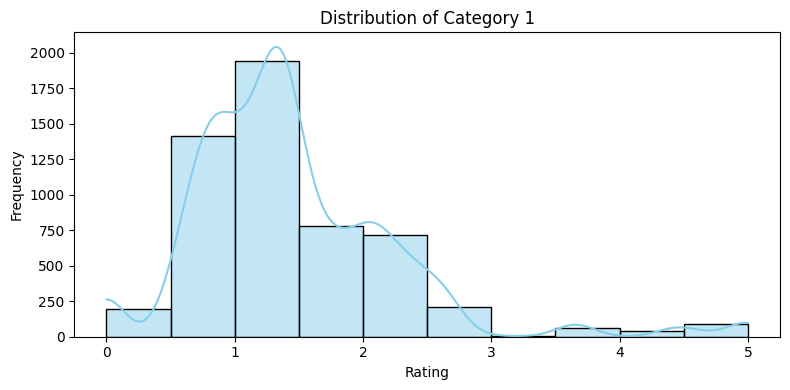

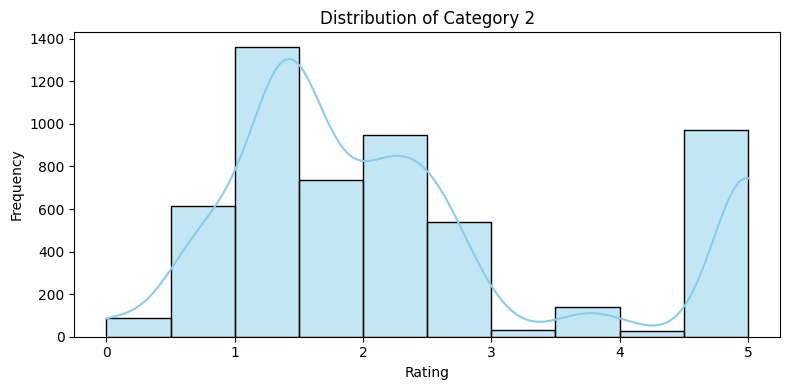

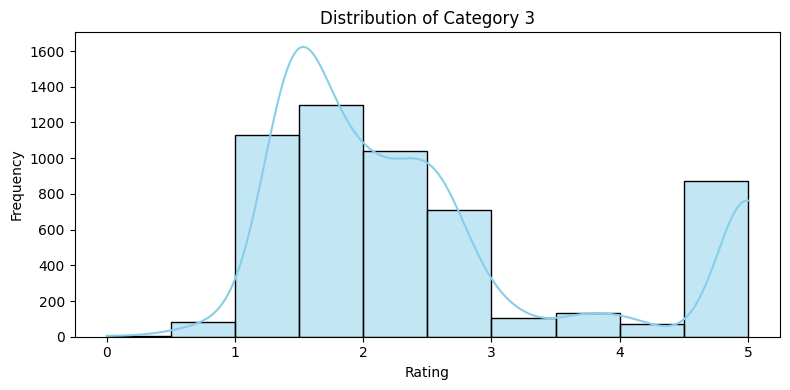

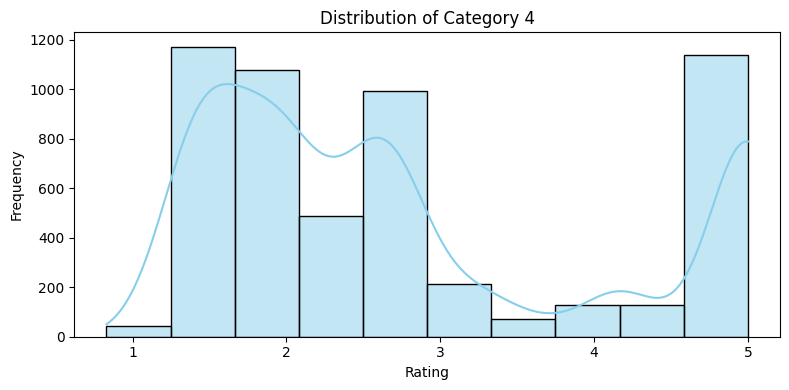

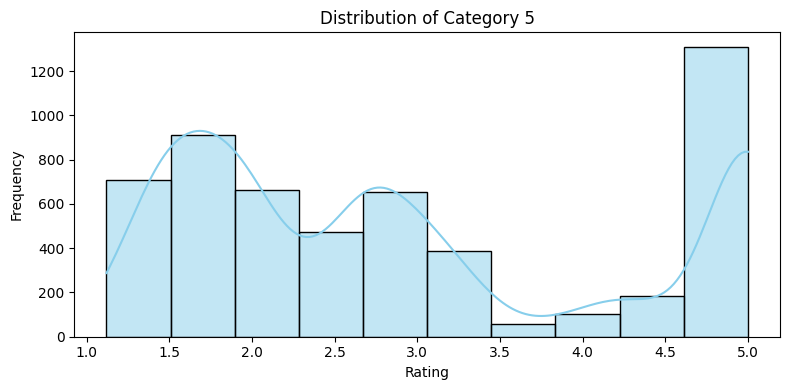

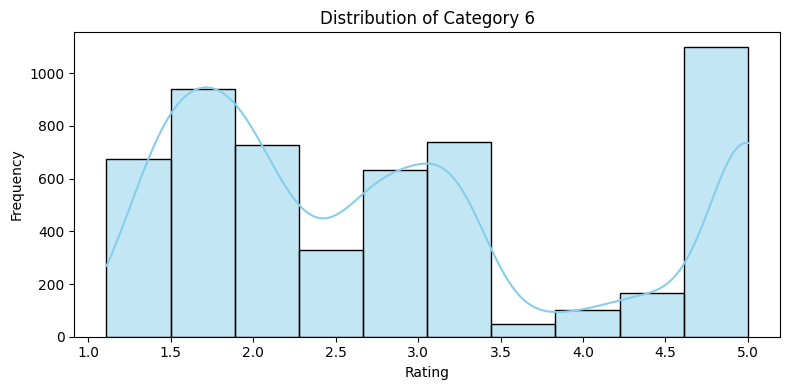

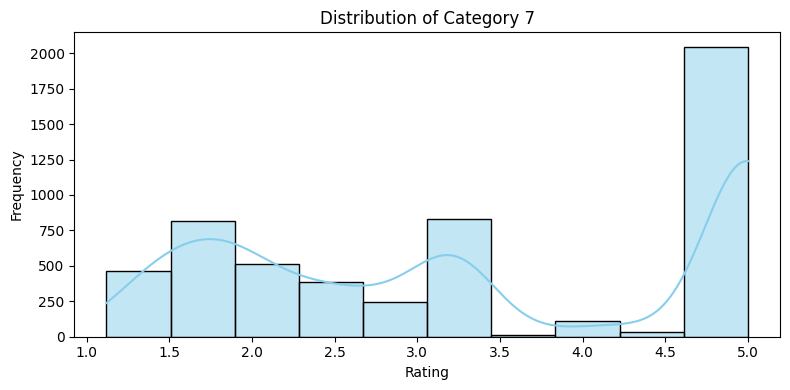

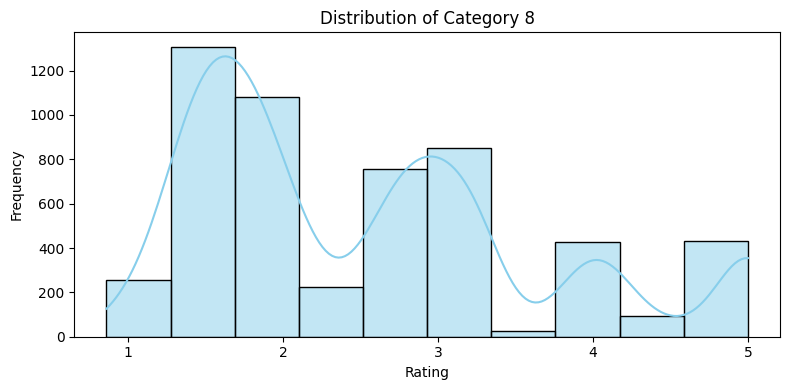

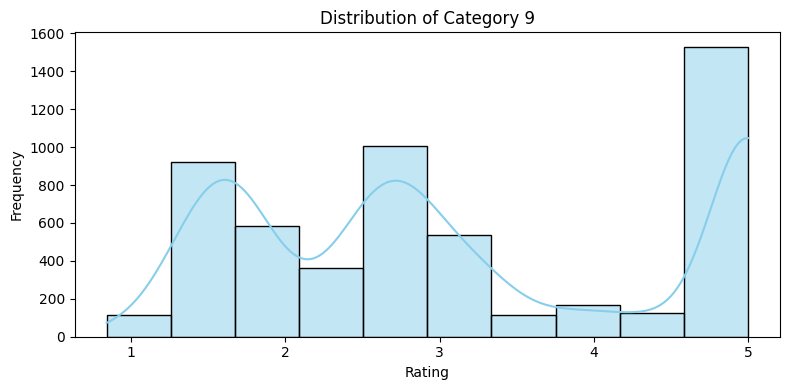

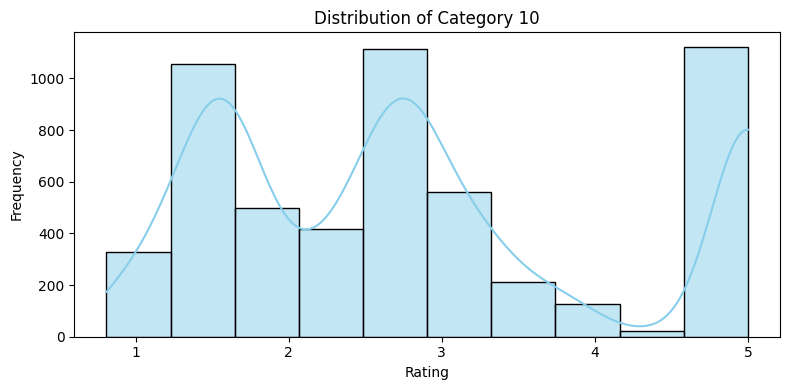

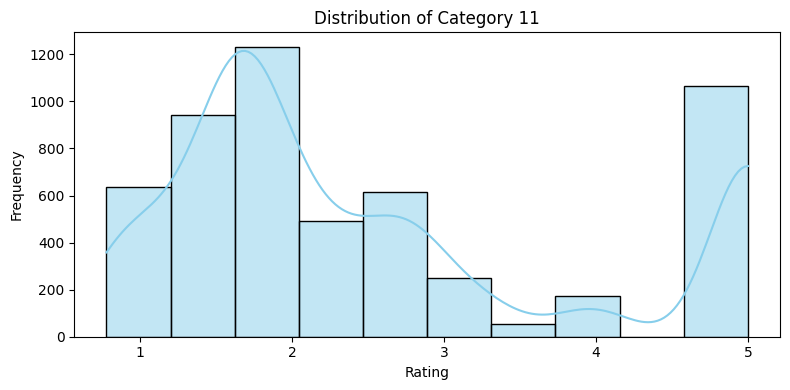

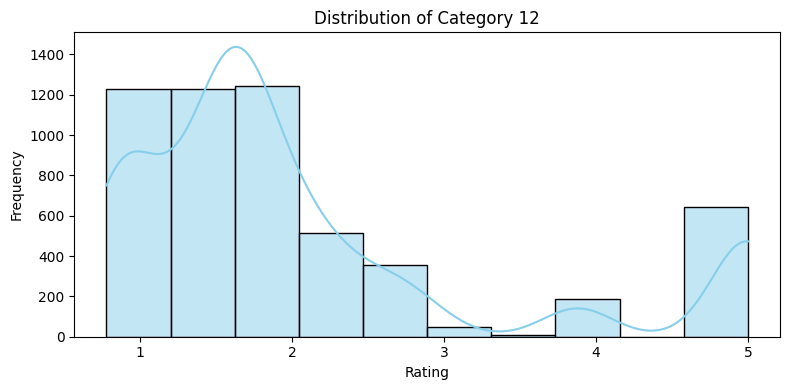

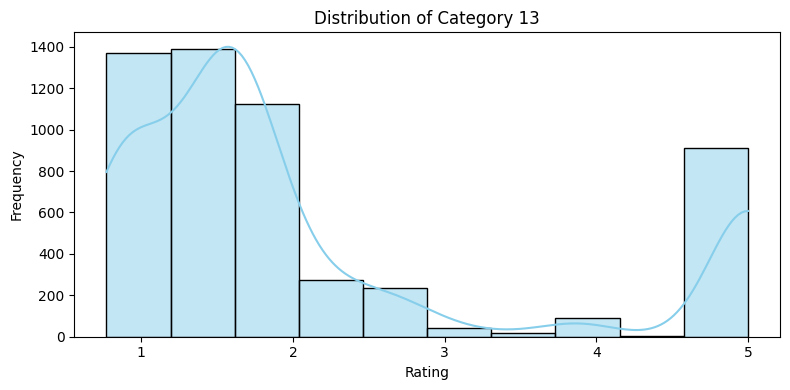

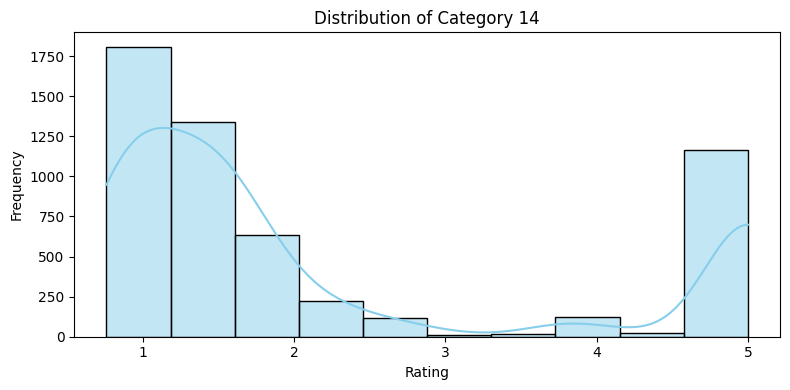

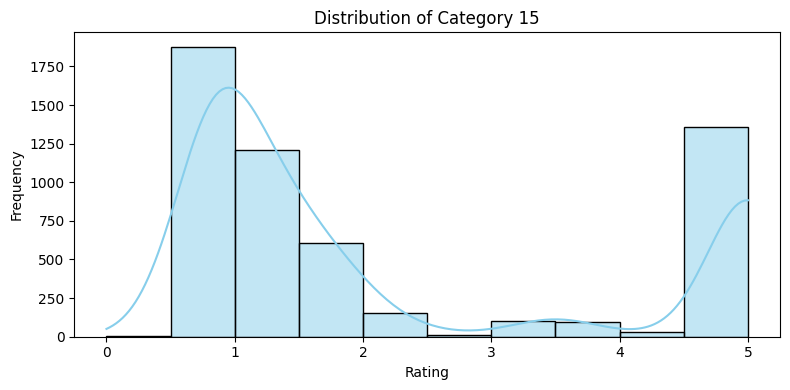

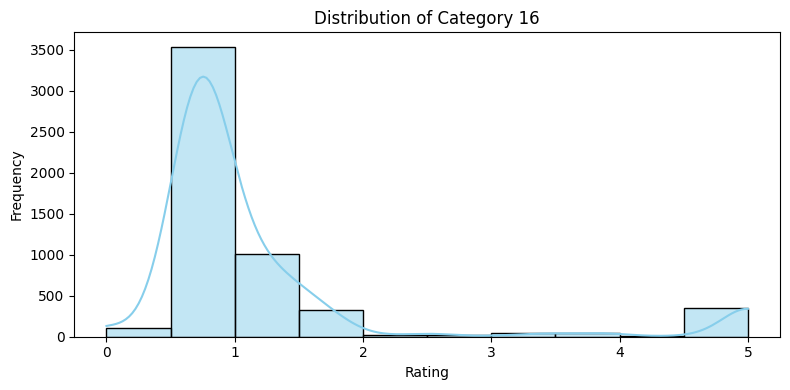

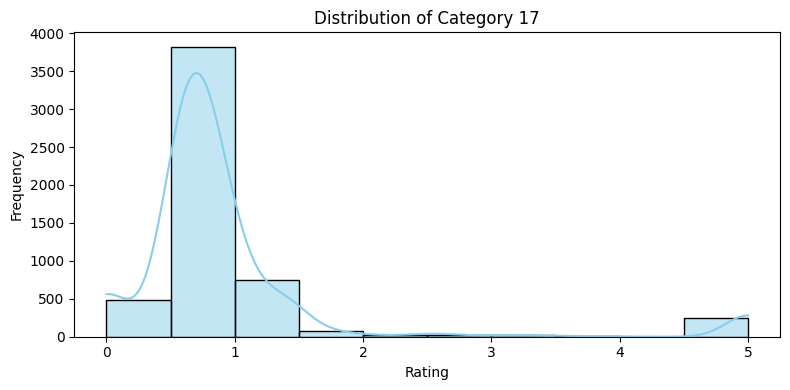

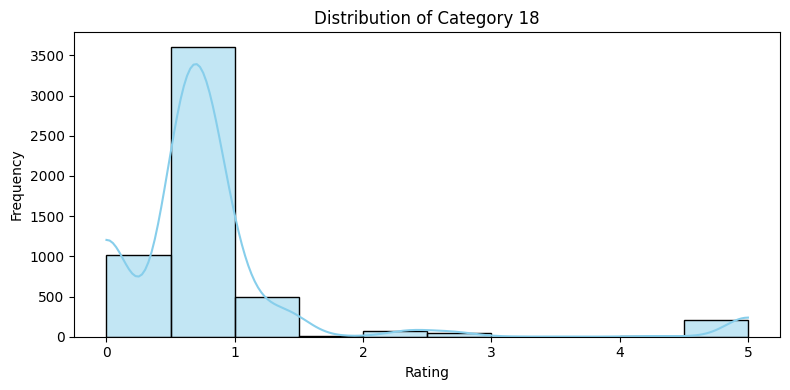

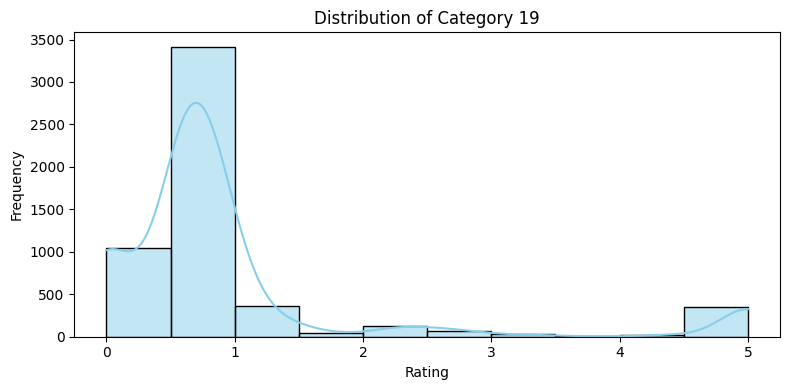

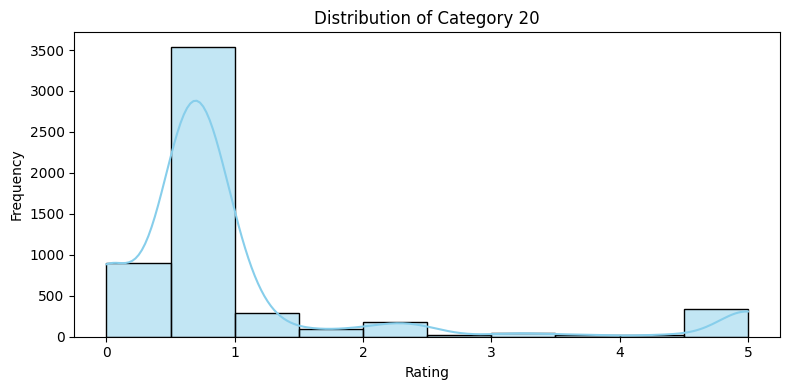

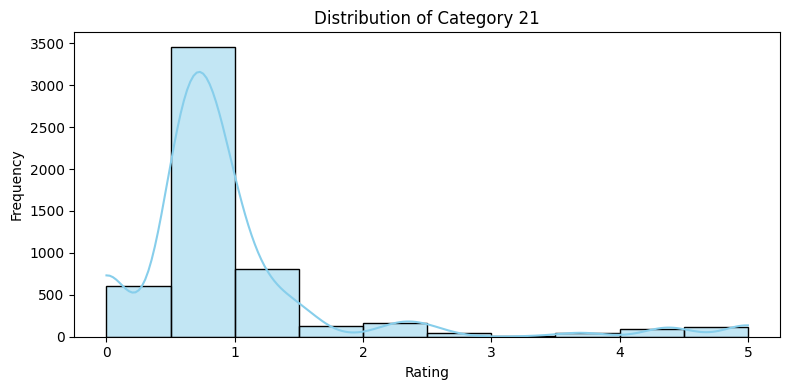

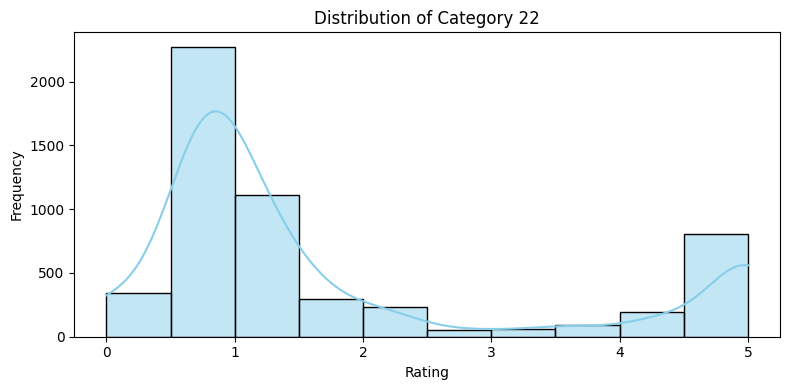

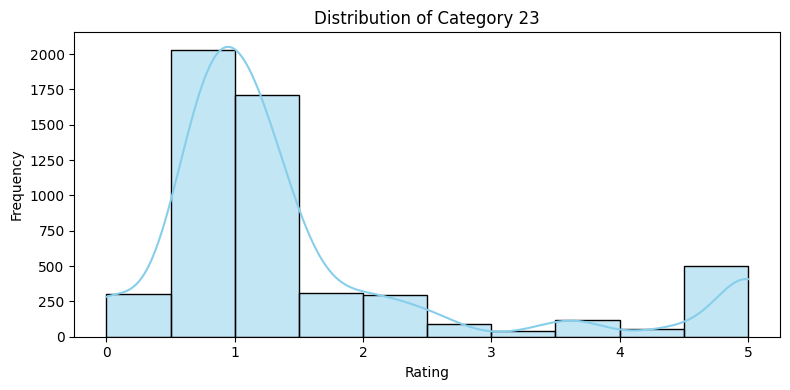

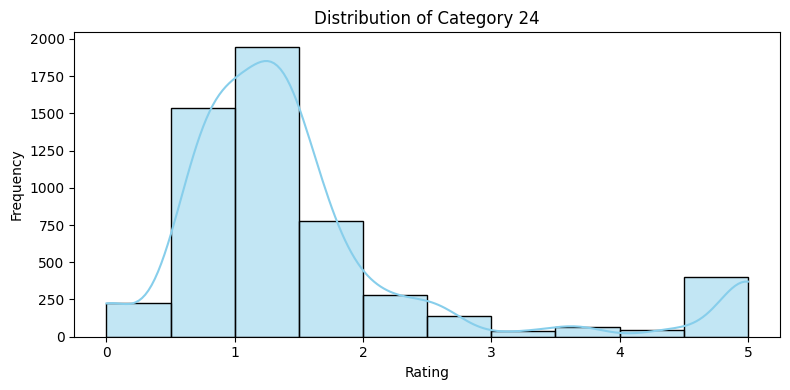

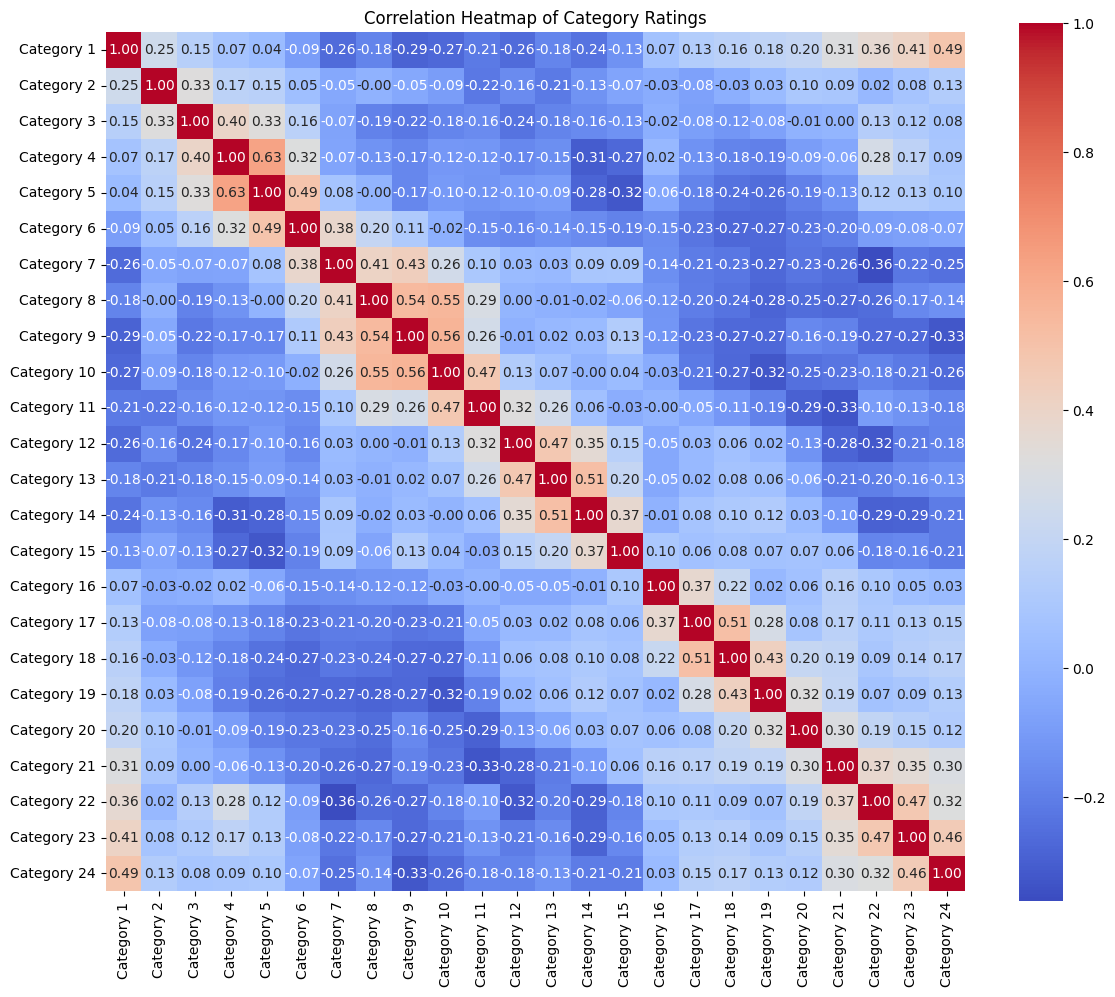

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "google_review_ratings.csv"
df = pd.read_csv(file_path)

# Drop 'Unnamed: 25' as it's mostly empty
df.drop(columns=['Unnamed: 25'], errors='ignore', inplace=True)

# Convert Category 11 to numeric (if possible), otherwise drop it
try:
    df['Category 11'] = pd.to_numeric(df['Category 11'], errors='coerce')  # Convert or NaN
except KeyError:
    pass  # If 'Category 11' doesn't exist, do nothing

# Clean up formatting issues (e.g., stray tabs '\t' in numbers)
df.replace(r'\t', '', regex=True, inplace=True)

# Fill missing values in numerical columns with their respective column means
for col in df.columns[1:]:  # Exclude 'User' column
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Ensure all are numeric
    df[col] = df[col].fillna(df[col].mean())  # Fill NaN with column mean

# Identify only numerical rating columns
category_cols = [col for col in df.columns if "Category" in col]

# Summary statistics after cleaning
print("Cleaned Data Summary:")
print(df.describe())

# Plot histograms with KDE for each category
for col in category_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=10, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Generate correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df[category_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Category Ratings')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# Copy or reference your cleaned dataframe 'df'
df_sentiment = df.copy()

# Identify all category columns
category_cols = [col for col in df_sentiment.columns if "Category" in col]

def rating_to_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating <= 2.0:
        return 'negative'
    else:
        return 'neutral'

# Create new columns for sentiment
for col in category_cols:
    df_sentiment[col + '_sentiment'] = df_sentiment[col].apply(rating_to_sentiment)

# Example check
print(df_sentiment.head())


     User  Category 1  Category 2  Category 3  Category 4  Category 5  \
0  User 1         0.0         0.0        3.63        3.65         5.0   
1  User 2         0.0         0.0        3.63        3.65         5.0   
2  User 3         0.0         0.0        3.63        3.63         5.0   
3  User 4         0.0         0.5        3.63        3.63         5.0   
4  User 5         0.0         0.0        3.63        3.63         5.0   

   Category 6  Category 7  Category 8  Category 9  ...  Category 15_sentiment  \
0        2.92         5.0        2.35        2.33  ...               negative   
1        2.92         5.0        2.64        2.33  ...               negative   
2        2.92         5.0        2.64        2.33  ...               negative   
3        2.92         5.0        2.35        2.33  ...               negative   
4        2.92         5.0        2.64        2.33  ...               negative   

   Category 16_sentiment  Category 17_sentiment  Category 18_sentiment  \


In [4]:
# Create an explicit user–category matrix
# If 'User' is unique for each row, set 'User' as index
df_cf = df.set_index('User')[category_cols]
print(df_cf.head())

# Now df_cf is a matrix where each row is a user and each column is a category rating


        Category 1  Category 2  Category 3  Category 4  Category 5  \
User                                                                 
User 1         0.0         0.0        3.63        3.65         5.0   
User 2         0.0         0.0        3.63        3.65         5.0   
User 3         0.0         0.0        3.63        3.63         5.0   
User 4         0.0         0.5        3.63        3.63         5.0   
User 5         0.0         0.0        3.63        3.63         5.0   

        Category 6  Category 7  Category 8  Category 9  Category 10  ...  \
User                                                                 ...   
User 1        2.92         5.0        2.35        2.33         2.64  ...   
User 2        2.92         5.0        2.64        2.33         2.65  ...   
User 3        2.92         5.0        2.64        2.33         2.64  ...   
User 4        2.92         5.0        2.35        2.33         2.64  ...   
User 5        2.92         5.0        2.64        2.3

# Train the Collaborative filtering (CF) model

In [ ]:
!pip install -q scikit-surprise


In [5]:
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Convert df_cf into a long format suitable for Surprise
df_long = df_cf.reset_index().melt(id_vars='User', var_name='Category', value_name='Rating')

# Prepare data for Surprise
reader = Reader(rating_scale=(0, 5))  # adjust if your rating scale is known
data = Dataset.load_from_df(df_long[['User', 'Category', 'Rating']], reader)

# Split into train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# User-based collaborative filtering
sim_options = {
    'name': 'pearson',      # or 'cosine'
    'user_based': True      # True for user-based CF
}
algo = KNNBasic(sim_options=sim_options)

# Train the model
algo.fit(trainset)

# Test the model
predictions = algo.test(testset)

# Evaluate performance
rmse = accuracy.rmse(predictions)
print("Test RMSE:", rmse)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505166 sha256=dcf65fdf44abee43185588860e50141e6fbbc40b94bde299081313e7ddbadfbc
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8874
Test RMSE: 0.8873983943276784


In [14]:
def rating_to_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating <= 2.0:
        return 'negative'
    else:
        return 'neutral'

def sentiment_label_to_score(label):
    if label == 'positive':
        return 1
    elif label == 'negative':
        return -1
    else:
        return 0


# Test the Trained Model

In [15]:
def get_recommendations(user_id, df_cf, df_sentiment, algo, alpha=0.8, beta=0.2, top_n=5):
    results = []

    for cat in df_cf.columns:
        pred = algo.predict(user_id, cat).est
        row_mask = (df_sentiment['User'] == user_id)
        sentiment_label = df_sentiment.loc[row_mask, cat + '_sentiment'].values[0]
        sentiment_num = sentiment_label_to_score(sentiment_label)

        weighted = alpha * pred + beta * sentiment_num
        results.append((cat, pred, sentiment_label, weighted))

    results_sorted = sorted(results, key=lambda x: x[3], reverse=True)
    best = results_sorted[:top_n]
    worst = results_sorted[-top_n:]

    return best, worst

user_id = "User 10"
best_places, least_places = get_recommendations(user_id, df_cf, df_sentiment, algo, alpha=0.8, beta=0.2, top_n=5)

print(f"\nTop 5 Recommendations for {user_id}:")
for cat, pred, sent, weighted in best_places:
    print(f"  {cat} | CF: {pred:.2f} | Sentiment: {sent} | Weighted: {weighted:.2f}")

print(f"\nLeast 5 Preferred for {user_id}:")
for cat, pred, sent, weighted in least_places:
    print(f"  {cat} | CF: {pred:.2f} | Sentiment: {sent} | Weighted: {weighted:.2f}")



Top 5 Recommendations for User 10:
  Category 2 | CF: 4.90 | Sentiment: positive | Weighted: 4.12
  Category 5 | CF: 4.73 | Sentiment: positive | Weighted: 3.98
  Category 4 | CF: 4.03 | Sentiment: neutral | Weighted: 3.22
  Category 3 | CF: 3.95 | Sentiment: neutral | Weighted: 3.16
  Category 6 | CF: 3.61 | Sentiment: neutral | Weighted: 2.89

Least 5 Preferred for User 10:
  Category 16 | CF: 0.62 | Sentiment: negative | Weighted: 0.29
  Category 21 | CF: 0.59 | Sentiment: negative | Weighted: 0.27
  Category 17 | CF: 0.34 | Sentiment: negative | Weighted: 0.07
  Category 19 | CF: 0.30 | Sentiment: negative | Weighted: 0.04
  Category 18 | CF: 0.23 | Sentiment: negative | Weighted: -0.01


# Save the model

In [10]:
import pickle

# Save the trained model
with open("cf_model.pkl", "wb") as model_file:
    pickle.dump(algo, model_file)

print("Model saved successfully!")


Model saved successfully!


# Load a saved CF-Model and use it

In [13]:
import pickle
import sys

def load_model(model_path="cf_model.pkl"):
    """Loads the trained collaborative filtering model from a file."""
    try:
        with open(model_path, "rb") as model_file:
            model = pickle.load(model_file)
        print("Model loaded successfully!")
        return model
    except FileNotFoundError:
        print("Error: Model file not found. Train and save the model first.")
        sys.exit(1)

def predict_rating(model, user_id, category):
    """Uses the loaded model to predict the rating for a given user and category."""
    prediction = model.predict(user_id, category)
    return prediction.est

if __name__ == "__main__":
    # Load the model
    model = load_model()

    # Example: Predict rating for a user-category pair
    user_id = input("Enter User ID: ")
    category = input("Enter Category: ")

    predicted_rating = predict_rating(model, user_id, category)
    print(f"Predicted rating for {user_id} on {category}: {predicted_rating:.2f}")


Model loaded successfully!
Enter User ID: 3
Enter Category: a
Predicted rating for 3 on a: 2.03
